# Fraud detection lab

## Visualisations

In [1]:
# insert code here
test = 5
print(test)

In [2]:
# we don't need any of the defined variables of this section. Therefore, we clean the workspace.
%reset -f





First of all, let's do some processing of the dataset we have.

### Preprocessing

In [22]:
import sys
!{sys.executable} -m pip install sklearn pandas

Looking in indexes: https://pypi.python.org/simple/


In [4]:
import time
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler

In [5]:
CSV_PATH = r"..\data\data_for_student_case.csv"
data_df = pd.read_csv(CSV_PATH)
print(data_df.shape)

(290382, 17)


Remove all the rows in which 'simple_journal' == 'Refused' --> not meaningful datapoints

In [6]:
data_df = data_df[data_df['simple_journal'] != 'Refused']
print(data_df.shape)

(237036, 17)


Transform some of the variables and investigate for NA values

In [7]:
data_df['cvcresponsecode'] = data_df['cvcresponsecode'].apply(lambda cvc: 3 if cvc >= 3 else cvc)

data_df = data_df.loc[~data_df['cardverificationcodesupplied'].isna()]
print(data_df.shape)

# transform labels into 0 and 1
data_df['label'] = data_df['simple_journal'].apply(lambda label: 1 if label == 'Chargeback' else 0)
data_df = data_df.drop(columns = ['simple_journal'])

(223842, 17)


In [8]:
#Extract day of the week and hour from the 'creationdate'
hours = []
day_week = []
month = []
for index, row in data_df.iterrows():
    hours.append(datetime.datetime.strptime(row['creationdate'].split()[1], '%H:%M:%S').hour)
    day_week.append(datetime.datetime.strptime(row['creationdate'].split()[0], '%Y-%m-%d').strftime('%A'))
    month.append(datetime.datetime.strptime(row['creationdate'].split()[0], '%Y-%m-%d').month)

for i in range(len(day_week)):
    if day_week[i] == 'Monday':
        day_week[i] = 0
    elif day_week[i] == 'Tuesday':
        day_week[i] = 1
    elif day_week[i] == 'Wednesday':
        day_week[i] = 2
    elif day_week[i] == 'Thursday':
        day_week[i] = 3
    elif day_week[i] == 'Friday':
        day_week[i] = 4
    elif day_week[i] == 'Saturday':
        day_week[i] = 5
    elif day_week[i] == 'Sunday':
        day_week[i] = 6

print(hours[:5])
print(day_week[:5])
print(month[:5])

data_df['hourtransaction'] = hours
data_df['daytransaction'] = day_week
data_df['monthtransaction'] = month

[23, 4, 14, 7, 18]
[2, 3, 3, 4, 2]
[7, 7, 7, 7, 7]


In [9]:
list(data_df.columns)

['txid',
 'bookingdate',
 'issuercountrycode',
 'txvariantcode',
 'bin',
 'amount',
 'currencycode',
 'shoppercountrycode',
 'shopperinteraction',
 'cardverificationcodesupplied',
 'cvcresponsecode',
 'creationdate',
 'accountcode',
 'mail_id',
 'ip_id',
 'card_id',
 'label',
 'hourtransaction',
 'daytransaction',
 'monthtransaction']

In [10]:
# convert amounts
conversion_rate = {"AUD": 0.626093,
                    "NZD": 0.591501,
                    "SEK": 0.0935468,
                    "GBP": 1.16536,
                    "MXN": 0.0467946}

data_df['amount'] = data_df[['amount', 'currencycode']].apply(lambda row: row['amount']*conversion_rate[row['currencycode']], axis=1)

data_df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,hourtransaction,daytransaction,monthtransaction
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,3032.29008,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,1,23,2,7
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,2101.07754,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1,4,3,7
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,7014.51054,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,1,14,3,7
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,5142.72654,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,1,7,4,7
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,4206.83454,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,1,18,2,7


In [11]:
# encode variables
for col_name in ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'accountcode']:
    unique_values = data_df[col_name].unique()
    mapped_values = dict(zip(unique_values, range(len(unique_values))))
    data_df[col_name] = data_df[col_name].apply(lambda old_value: mapped_values[old_value])

data_df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,hourtransaction,daytransaction,monthtransaction
0,1,2015-11-09 14:26:51,0,0,530056.0,3032.29008,0,0,0,True,0,2015-07-01 23:03:11,0,email68370,ip111778,card184798,1,23,2,7
1,2,2015-11-09 14:27:38,0,0,547046.0,2101.07754,0,0,0,True,0,2015-07-02 04:50:55,0,email101299,ip78749,card151595,1,4,3,7
2,3,2015-11-23 16:34:16,0,0,528843.0,7014.51054,0,0,0,True,0,2015-07-02 14:30:28,0,email278604,ip70594,card242142,1,14,3,7
3,4,2015-11-23 16:34:51,0,0,547146.0,5142.72654,0,0,0,True,0,2015-07-03 07:53:37,0,email47409,ip113648,card181744,1,7,4,7
4,5,2015-11-09 14:26:08,0,1,477291.0,4206.83454,0,0,0,True,0,2015-07-08 18:35:35,0,email205501,ip83553,card97271,1,18,2,7


In [12]:
# Check correlation between 'issuercountrycode', 'currencycode', 'shoppercountrycode', 'accountcode'

col_names = ['issuercountrycode', 'currencycode', 'shoppercountrycode', 'accountcode']
temp_df = data_df[col_names]

temp_df.corr()

,issuercountrycode,currencycode,shoppercountrycode,accountcode
issuercountrycode,1.000000,0.684937,0.614083,0.664023
currencycode,0.684937,1.000000,0.643947,0.973466
shoppercountrycode,0.614083,0.643947,1.000000,0.683598
accountcode,0.664023,0.973466,0.683598,1.000000


In [13]:
#'currencycode' and 'accountcode' are strongly correlate: 0.973469 so we only keep one -> 'accountcode'

data_df = data_df.drop(columns = ['currencycode'])
print(data_df.shape)

(223842, 19)


In [14]:
# drop columns which are not used
data_df = data_df.drop(columns=['txid', 'bookingdate', 'creationdate', 'mail_id', 'card_id', 'ip_id', 'bin'])
print(data_df.shape)

(223842, 12)


In [15]:
# Normalize 'amount'
data_df['amount_normalized'] = StandardScaler().fit_transform(data_df['amount'].values.reshape(-1, 1))
data_df = data_df.drop(columns=['amount'])
data_df.head()

,issuercountrycode,txvariantcode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,label,hourtransaction,daytransaction,monthtransaction,amount_normalized
0,0,0,0,0,True,0,0,1,23,2,7,-0.695624
1,0,0,0,0,True,0,0,1,4,3,7,-0.832027
2,0,0,0,0,True,0,0,1,14,3,7,-0.112313
3,0,0,0,0,True,0,0,1,7,4,7,-0.386489
4,0,1,0,0,True,0,0,1,18,2,7,-0.523578


In [16]:
# columns we remain with
list(data_df.columns)

['issuercountrycode',
 'txvariantcode',
 'shoppercountrycode',
 'shopperinteraction',
 'cardverificationcodesupplied',
 'cvcresponsecode',
 'accountcode',
 'label',
 'hourtransaction',
 'daytransaction',
 'monthtransaction',
 'amount_normalized']

In [17]:
# save the file
data_df.to_csv(r'..\data\data_processed_new.csv',index=False)

In [21]:
# we saved the processed file, so variables are not needed for the following sections.
%reset -f

# Imbalance task

In [1]:
import sys
!{sys.executable} -m pip install imblearn matplotlib

Looking in indexes: https://pypi.python.org/simple/


In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DATA_PATH = r"../data/"
DATA_FILE = "data_processed_new.csv"
df = pd.read_csv(DATA_PATH + DATA_FILE)
df.head()

,issuercountrycode,txvariantcode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,label,hourtransaction,daytransaction,monthtransaction,amount_normalized
0,0,0,0,0,True,0,0,1,23,2,7,-0.695624
1,0,0,0,0,True,0,0,1,4,3,7,-0.832027
2,0,0,0,0,True,0,0,1,14,3,7,-0.112313
3,0,0,0,0,True,0,0,1,7,4,7,-0.386489
4,0,1,0,0,True,0,0,1,18,2,7,-0.523578


In [4]:
# Let's split into features and labels
y = df['label']
X = df.drop(columns=['label'])

In [11]:
classifiers = [
    ("Ada", AdaBoostClassifier(n_estimators=100)),
    ("rf", RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    ("lr", LogisticRegression(solver='liblinear')),
    ("kNN", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ("NB", GaussianNB()),
]
smote_values = [0, 0.015, 0.025, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]

In [12]:
# We first split in train and test set. The test set will be only used for plotting the curves.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# We then split the train set into train and validation. Validation will be used to select the best smote value.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

Let's now compute, for each of the chosen classifiers, different metrics for different percentages of SMOTE.    
We choose F0.5 as the metric to decide the best value of SMOTE. NOTE: each classifier can have a different SMOTE best parameter!



Using 'Ada'


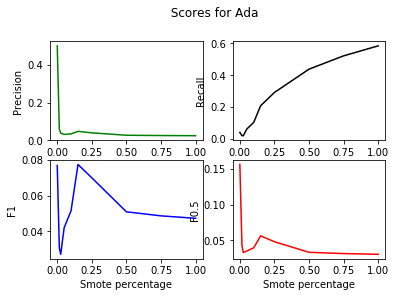

Max 'Precision' --> 0.5 (SMOTE perc: 0)
Max 'Recall' --> 0.5833333333333334 (SMOTE perc: 1.0)
Max 'F1' --> 0.07751937984496124 (SMOTE perc: 0.15)
Max 'F0.5' --> 0.15625 (SMOTE perc: 0)


Using 'rf'


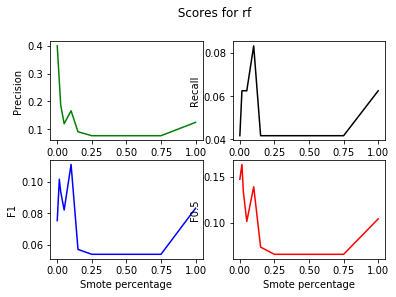

Max 'Precision' --> 0.4 (SMOTE perc: 0)
Max 'Recall' --> 0.08333333333333333 (SMOTE perc: 0.1)
Max 'F1' --> 0.1111111111111111 (SMOTE perc: 0.1)
Max 'F0.5' --> 0.16304347826086957 (SMOTE perc: 0.015)


Using 'lr'


C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


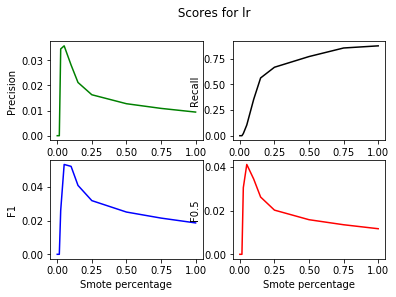

Max 'Precision' --> 0.03571428571428571 (SMOTE perc: 0.05)
Max 'Recall' --> 0.875 (SMOTE perc: 1.0)
Max 'F1' --> 0.05319148936170212 (SMOTE perc: 0.05)
Max 'F0.5' --> 0.041118421052631575 (SMOTE perc: 0.05)


Using 'kNN'


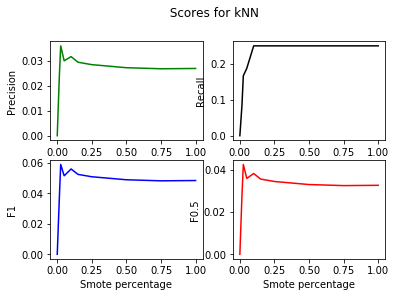

Max 'Precision' --> 0.03587443946188341 (SMOTE perc: 0.025)
Max 'Recall' --> 0.25 (SMOTE perc: 0.1)
Max 'F1' --> 0.05904059040590406 (SMOTE perc: 0.025)
Max 'F0.5' --> 0.0425531914893617 (SMOTE perc: 0.025)


Using 'NB'


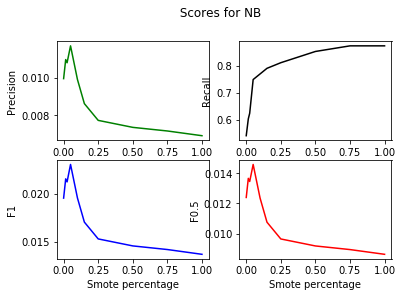

Max 'Precision' --> 0.01171875 (SMOTE perc: 0.05)
Max 'Recall' --> 0.875 (SMOTE perc: 0.75)
Max 'F1' --> 0.023076923076923078 (SMOTE perc: 0.05)
Max 'F0.5' --> 0.014591439688715954 (SMOTE perc: 0.05)
[0, 0.015, 0.05, 0.025, 0.05]


In [13]:
best_smotes = []
for clsf_name, clsf in classifiers:
    print(f"\n\nUsing '{clsf_name}'")
    acc = []
    recall = []
    precision = []
    f05_score = []
    f1_score = []
    roc_auc = []
    conf_mat = []
    for smote_perc in smote_values:
        #print(f'--- SMOTE PERCENTAGE: {smote_perc} ---')
        #print(f"Before SMOTE on train: {Counter(y_train)}")
        #print(f"Before SMOTE on validation: {Counter(y_val)}")

        smt = SMOTE(sampling_strategy=smote_perc) if smote_perc else None
        X_smote, y_smote = smt.fit_sample(X_train, y_train) if smote_perc else (X_train, y_train)

        #print(f"After SMOTE on train: {Counter(y_smote)}")
        #print(f"After SMOTE on validation: {Counter(y_val)}")

        clsf.fit(X_smote, y_smote)
        y_pred = clsf.predict(X_val)

        acc.append(metrics.accuracy_score(y_val, y_pred))
        recall.append(metrics.recall_score(y_val, y_pred))
        precision.append(metrics.precision_score(y_val, y_pred))
        f05_score.append(metrics.fbeta_score(y_val, y_pred, beta=0.5))
        f1_score.append(metrics.f1_score(y_val, y_pred))
        roc_auc.append(metrics.roc_auc_score(y_val, y_pred))
        conf_mat.append(metrics.confusion_matrix(y_val, y_pred))

    fig = plt.figure()
    fig.suptitle(f" Scores for {clsf_name}", y=1)

    plt.subplot(2, 2, 1)
    plt.plot(smote_values, precision, color='green', label='precision')
    plt.xlabel("Smote percentage")
    plt.ylabel("Precision")

    plt.subplot(2, 2, 2)
    plt.plot(smote_values, recall, color='black', label='recall')
    plt.xlabel("Smote percentage")
    plt.ylabel("Recall")

    plt.subplot(2, 2, 3)
    plt.plot(smote_values, f1_score, color='blue', label='F1')
    plt.xlabel("Smote percentage")
    plt.ylabel("F1")


    plt.subplot(2, 2, 4)
    plt.plot(smote_values, f05_score, color='red', label='F0.5')
    plt.xlabel("Smote percentage")
    plt.ylabel("F0.5")

    plt.show()

    for metric_name, mets in zip(["Precision", "Recall", "F1", "F0.5", ], [precision, recall, f1_score, f05_score]):
        max_ind = np.argmax(mets)
        print(f"Max '{metric_name}' --> {mets[max_ind]} (SMOTE perc: {smote_values[max_ind]})")
        #print(conf_mat[max_ind])

        if metric_name == "F0.5":
            best_smotes.append(smote_values[max_ind])
            
print(list(best_smotes))

We now retrain the models on train + validation set, and plot the curves using the test set

Ada --> 0


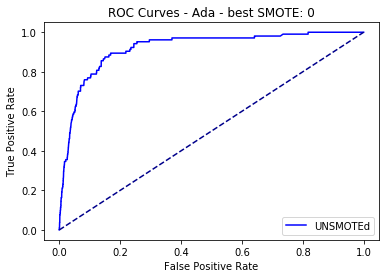

rf --> 0.015


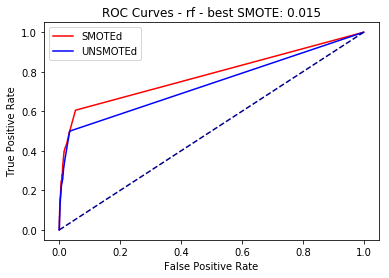

lr --> 0.05


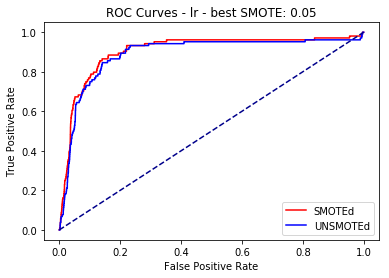

kNN --> 0.025


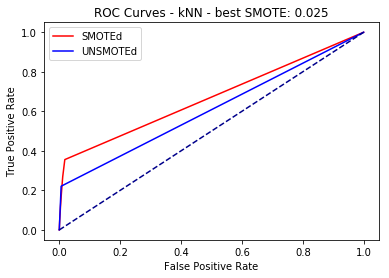

NB --> 0.05


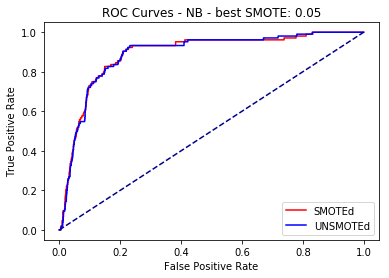

In [14]:
for (clsf_name, clsf), best_smote in zip(classifiers, best_smotes):
    print(f"{clsf_name} --> {best_smote}")

    fpr_smoted = []
    tpr_smoted = []
    if best_smote:
        smt = SMOTE(sampling_strategy=best_smote)
        X_smote, y_smote = smt.fit_sample(X_train_val, y_train_val)
        clsf.fit(X_smote, y_smote)
        y_pred = clsf.predict(X_test)

        probs_smoted = clsf.predict_proba(X_test)
        probs_smoted = probs_smoted[:, 1]
        fpr_smoted, tpr_smoted, _ = roc_curve(y_test, probs_smoted)
        plt.plot(fpr_smoted, tpr_smoted, color='red', label='SMOTEd')

    clsf.fit(X_train_val, y_train_val)
    y_pred = clsf.predict(X_test)
    probs_smoted = clsf.predict_proba(X_test)
    probs_smoted = probs_smoted[:, 1]
    fpr_unsmoted, tpr_unsmoted, _ = roc_curve(y_test, probs_smoted)
    plt.plot(fpr_unsmoted, tpr_unsmoted, color='blue', label='UNSMOTEd')

    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {clsf_name} - best SMOTE: {best_smote}')
    plt.legend()
    plt.show()


## Classification

In [ ]:
# we reload the data, so variables are not needed
%reset -f

### White box model

### Black box model

## Bonus point

In [10]:
# insert code here